In [1]:
from IPython import get_ipython
ipython = get_ipython()
if ipython is not None:
    ipython.run_line_magic('load_ext', 'autoreload')
    ipython.run_line_magic('autoreload', '2')
else:
    print("could not load extension")

In [2]:
%reload_ext autoreload

In [3]:
import getpass

user = getpass.getuser()
from omni.isaac.kit import SimulationApp

# Set the path below to your desired nucleus server
# Make sure you installed a local nucleus server before this
# and that isaacsim is running
simulation_app = SimulationApp({"livesync_usd": f"omniverse://localhost/Users/{user}/power_thermal_demo.usd"})

[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] =========================== DEPRECATION WARNING ===========================
[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] Traceback (most recent call last):
[Warning] [omni.isaac.kit] File '/home/ljb/.local/share/ov/pkg/isaac-sim-4.1.0/kit/python/lib/python3.10/runpy.py', line 196
[Warning] [omni.isaac.kit]   return _run_code(code, main_globals, None,
[Warning] [omni.isaac.kit] File '/home/ljb/.local/share/ov/pkg/isaac-sim-4.1.0/kit/python/lib/python3.10/runpy.py', line 86
[Warning] [omni.isaac.kit]   exec(code, run_globals)
[Warning] [omni.isaac.kit] File '/home/ljb/.local/share/ov/pkg/isaac-sim-4.1.0/kit/python/lib/python3.10/site-packages/ipykernel_launcher.py', line 18
[Warning] [omni.isaac.kit]   app.launch_new_instance()
[Warning] [omni.isaac.kit] File '/home/ljb/.local/share/ov/pkg/isaac-sim-4.1.0/kit/python/lib/python3.10/site-packages/traitlets/config/application.py', line 1075
[Warning] [omni.isaac.kit]   app.sta

it.widget.filter-1.1.4] startup
[1.631s] [ext: omni.graph.core-2.170.3] startup
[1.635s] [ext: omni.kit.window.extensions-1.4.9] startup
[1.641s] [ext: omni.kit.hotkeys.core-1.3.3] startup
[1.642s] [ext: omni.kit.context_menu-1.8.0] startup
[1.643s] [ext: omni.mdl-52.0.1] startup
[1.662s] [ext: omni.iray.libs-0.0.0] startup
[1.666s] [ext: omni.kit.primitive.mesh-1.0.16] startup
[1.669s] [ext: omni.kit.stage_template.core-1.1.21] startup
[1.670s] [ext: omni.mdl.neuraylib-0.2.5] startup
[1.671s] [ext: omni.ujitso.processor.texture-1.0.0] startup
[1.672s] [ext: omni.kit.window.file_exporter-1.0.29] startup
[1.674s] [ext: omni.kit.stage_templates-1.2.3] startup
[1.676s] [ext: omni.volume-0.5.0] startup
[1.678s] [ext: omni.ujitso.client-0.0.0] startup
[1.679s] [ext: omni.kit.window.file_importer-1.1.11] startup
[1.680s] [ext: omni.kit.window.drop_support-1.0.2] startup
[1.680s] [ext: omni.kit.window.file-1.3.52] startup
[1.684s] [ext: omni.kit.window.content_browser_registry-0.0.6] startup


Warp 1.2.1 initialized:
   CUDA Toolkit 11.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3060" (12 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/ljb/.cache/warp/1.2.1
2.745s] [ext: omni.ui_query-1.1.2] startup
[2.746s] [ext: omni.fabric.commands-1.1.4] startup
[2.753s] [ext: omni.physx.vehicle-106.0.20] startup
[2.770s] [ext: omni.kit.manipulator.prim.core-107.0.3] startup
[2.778s] [ext: omni.kit.graph.editor.core-1.5.3] startup
[2.782s] [ext: omni.kit.ui_test-1.2.18] startup
[2.784s] [ext: omni.kit.graph.usd.commands-1.3.1] startup
[2.785s] [ext: omni.physx.camera-106.0.20] startup
[2.796s] [ext: omni.kit.manipulator.prim.fabric-106.0.1] startup
[2.799s] [ext: omni.kit.manipulator.prim.usd-106.0.1] startup
[2.801s] [ext: omni.physx.cct-106.0.20] startup
[2.813s] [ext: omni.physics.tensors-106.0.20] startup
[2.825s] [ext: omni.isaac.version-1.1.0] startup
[2.827s] [ext: omni.kit.manipulator.selection-104.0.9] startup
[2.831s] [ex

AttributeError: 'NoneType' object has no attribute 'set_tooltip'

In [4]:
import carb
from omni.physx import get_physx_scene_query_interface  # for raycasting e.g raycast_closest()
from omni.isaac.core import World
from omni.isaac.core.objects import DynamicCuboid, DynamicSphere, DynamicCone
from omni.timeline import get_timeline_interface
from omni.isaac.core.utils.stage import get_current_stage
import omni.isaac.core.utils.prims as prims_utils

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [5]:
from mesh_raycast_utils import adjust_light, get_mesh_vertices_world, get_rect_areas, get_rect_normals, get_quad_centers, color_conversion, compute_sun_to_mesh, set_prim_orientation_euler, quick_stats
from power_thermal_computation import compute_power, compute_thermal_node, compute_thermal_surface

# Setup Simple Scene
Sun + Flat Plane (lunar surface) + Solar Panel

In [6]:
world = World(stage_units_in_meters=1.0)
stage = get_current_stage()

In [7]:
world.clear()
# world.scene.add_default_ground_plane()
# A render/ step or an update call is needed to reflect the changes to the opened USD in Isaac Sim GUI
#  Note: avoid pressing play/ pause or stop in the GUI in this workflow.
world.render()

In [8]:
# Create the Sun
sun = prims_utils.create_prim(
    "/World/Sun",
    "SphereLight",
    position=np.array([1.0, 1.0, 1.0]),
    attributes={
        "inputs:radius": 1,
        "inputs:intensity": 5e3,
        "inputs:color": (1.0, 1.0, 1.0)
    }
)
world.render()

In [9]:
# Define Sun position
# sun_coord = (5, 5, 5)
# sun_coord = (-5, -5, 5)
sun_coord = (8, -5, 3)
sun_coord = (-5, 5, 5)

adjust_light(stage, sun_coord)
world.render()

In [10]:
# Load a USD prepared with the meshes of ground + solar panel + two supports

# IMPORTANT: First time: copy paste the usd from the github repository to the nucleus server
# from: <path to the repository>/jaops-sim/scenes/assets/simplified_surface_solar_panel.usd
# to: omniverse://localhost/Users/<your username>/simplified_surface_solar_panel.usd
# (you can copy paste within the IsaacSim Content Window)

usd_path = f"omniverse://localhost/Users/{user}/simplified_surface_solar_panel.usd"
prim_path = "/World/Lunar_Base"

ground_path = prim_path + "/Ground"
panel_path = prim_path + "/Solar_Generator/Panel"
support1_path = prim_path + "/Solar_Generator/Support1"
support2_path = prim_path + "/Solar_Generator/Support2"
all_paths = [ground_path, panel_path, support1_path, support2_path]
# create the prim
prim = prims_utils.create_prim(prim_path=prim_path, usd_path=usd_path)
world.render()

In [11]:
timeline = get_timeline_interface()
timeline.play()
for _ in range(2):
    simulation_app.update()
timeline.pause()

# Solar Power Generation

In [12]:
# get point centers
face_vertex_indices = prims_utils.get_prim_attribute_value(panel_path, "faceVertexIndices")
points_world = get_mesh_vertices_world(stage, panel_path)

quad_centers = get_quad_centers(points_world, face_vertex_indices)

In [13]:
length, width, height = prims_utils.get_prim_attribute_value(
    panel_path, "xformOp:scale"
)
cell_area = length * width / 100

In [14]:
dot_products = compute_sun_to_mesh(quad_centers)
power_generation = compute_power(dot_products, cell_area)
power_colors = color_conversion(power_generation, add_tail=True)

In [15]:
prims_utils.set_prim_attribute_value(panel_path, "primvars:displayColor", power_colors)
world.render()

## Animated solar power computation

In [16]:
N = 100
panel_angles = np.zeros((N, 3)) 
panel_angles[:,0] = np.linspace(-50, 50, num=N)

sun_angles = np.zeros((N, 3))
sun_angles[:,0] = 3 * np.cos(np.linspace(0, 3.14, num=N))
sun_angles[:,1] = 3 * np.sin(np.linspace(0, 3.14, num=N))
sun_angles[:,2] = np.linspace(.05, 7.5, num=N)

In [17]:
set_prim_orientation_euler(panel_path, [0, 0 , 0], degrees=True)
world.render()

In [18]:
length, width, height = prims_utils.get_prim_attribute_value(
    panel_path, "xformOp:scale"
)
cell_area = length * width / 100

power_gens = []
for p,s in zip(panel_angles, sun_angles):
    set_prim_orientation_euler(panel_path, p, degrees=True)
    adjust_light(stage, tuple(s))
    
    timeline.play()
    for _ in range(2):
        simulation_app.update()
    timeline.pause()

    face_vertex_indices = prims_utils.get_prim_attribute_value(panel_path, "faceVertexIndices")
    points_world = get_mesh_vertices_world(stage, panel_path)
    quad_centers = get_quad_centers(points_world, face_vertex_indices)

    dot_products = compute_sun_to_mesh(quad_centers)
    power_generation = compute_power(dot_products, cell_area)
    power_gens.append(np.nansum(power_generation[:100]))  # solar cells are only on top of mesh
    power_colors = color_conversion(power_generation, norm_mode=[0, 1], add_tail=True)
    power_colors[100:] = 0  # solar cells are only on top of mesh
    prims_utils.set_prim_attribute_value(panel_path, "primvars:displayColor", power_colors)
    world.render()

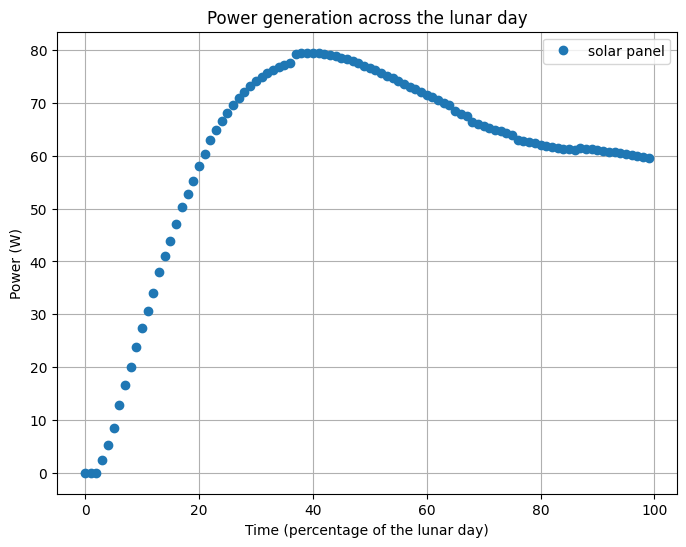

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(power_gens, 'o', label='solar panel')
plt.title('Power generation across the lunar day')
plt.ylabel('Power (W)')
plt.xlabel('Time (percentage of the lunar day)')
plt.legend()
plt.grid(True)
plt.show()

# Thermal Computation

## Lunar Surface Thermal 

In [20]:
from power_thermal_computation import LUNAR_ALPHA, LUNAR_EPSILON, SUN_POWER, SIGMA

In [21]:
face_vertex_indices = prims_utils.get_prim_attribute_value(ground_path, "faceVertexIndices")
points_world = get_mesh_vertices_world(stage, ground_path)
quad_centers = get_quad_centers(points_world, face_vertex_indices)
sun_dot_products = compute_sun_to_mesh(quad_centers, output='dotproducts')
normals = get_rect_normals(points_world, face_vertex_indices)

in get_rect_normals(): assuming rectangles


In [22]:
temperatures = compute_thermal_surface(sun_dot_products, normals, LUNAR_ALPHA, LUNAR_EPSILON)
pprint(quick_stats(temperatures),  sort_dicts=False)

{'mean': 238.0,
 'median': 372.4,
 'std': 174.3,
 'min': 0.0,
 'max': 390.9,
 '25%': 0.0,
 '50%': 372.4,
 '75%': 383.4,
 'NaN count': 100,
 'NaN %': 35.7}


/home/ljb/jaops/jaops-sim/src/demo_power_thermal/power_thermal_computation.py:175: RuntimeWarning: invalid value encountered in divide
  temperatures = (q_sun / q_space) ** (1 / 4)


In [23]:
temperature_colors = color_conversion(temperatures, add_tail=True)
prims_utils.set_prim_attribute_value(ground_path, "primvars:displayColor", temperature_colors)
world.render()

## Lunar Surface Animated

In [24]:
minmax = [100, 400]

# lunar surface is static so only compute geometric aspects once
face_vertex_indices = prims_utils.get_prim_attribute_value(ground_path, "faceVertexIndices")
points_world = get_mesh_vertices_world(stage, ground_path)
normals = get_rect_normals(points_world, face_vertex_indices)
quad_centers = get_quad_centers(points_world, face_vertex_indices)

# update computations for panel and sun angle movements 
for p,s in zip(panel_angles, sun_angles):
    set_prim_orientation_euler(panel_path, p, degrees=True)
    adjust_light(stage, tuple(s))
    
    timeline.play()
    for _ in range(5):
        simulation_app.update()
    timeline.pause()

    sun_dot_products = compute_sun_to_mesh(quad_centers, output='dotproducts')
    temperatures = compute_thermal_surface(sun_dot_products, normals, LUNAR_ALPHA, LUNAR_EPSILON)
    
    #temperature_colors = color_conversion(temperatures, norm_mode=minmax, add_tail=True)
    temperature_colors = color_conversion(temperatures, norm_mode='minmax', add_tail=True)
    temperature_colors[100:] = 0  # only keep the top face of the lunar surface, set the other faces to black
    prims_utils.set_prim_attribute_value(ground_path, "primvars:displayColor", temperature_colors)
    world.render()

in get_rect_normals(): assuming rectangles


## Solar Panel Thermal

In [25]:
from power_thermal_computation import PANEL_ALPHA, PANEL_EPSILON

In [26]:
face_vertex_indices = prims_utils.get_prim_attribute_value(panel_path, "faceVertexIndices")
points_world = get_mesh_vertices_world(stage, panel_path)
quad_centers = get_quad_centers(points_world, face_vertex_indices)
sun_dot_products = compute_sun_to_mesh(quad_centers, output='dotproducts')
normals = get_rect_normals(points_world, face_vertex_indices)
rect_areas = get_rect_areas(points_world, face_vertex_indices)

in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles


In [27]:
panel_temperature = compute_thermal_node(
    sun_dot_products,
    rect_areas,
    normals,
    PANEL_ALPHA,
    PANEL_EPSILON
)
f"{panel_temperature:.0f} degK"

'357 degK'

In [28]:
temperature_colors = color_conversion(np.ones(len(points_world)) * panel_temperature, [150, 400], add_tail=True)
prims_utils.set_prim_attribute_value(panel_path, "primvars:displayColor", temperature_colors)
world.render()

## Panel Supports Thermal

In [29]:
from power_thermal_computation import SUPPORT_ALPHA, SUPPORT_EPSILON

In [30]:
for path in [support1_path, support2_path]:
    
    face_vertex_indices = prims_utils.get_prim_attribute_value(path, "faceVertexIndices")
    points_world = get_mesh_vertices_world(stage, path)
    quad_centers = get_quad_centers(points_world, face_vertex_indices)
    sun_dot_products = compute_sun_to_mesh(quad_centers, output='dotproducts')
    
    normals = get_rect_normals(points_world, face_vertex_indices)
    rect_areas = get_rect_areas(points_world, face_vertex_indices)
    
    panel_temperature = compute_thermal_node(
        sun_dot_products,
        rect_areas,
        normals,
        SUPPORT_ALPHA,
        SUPPORT_EPSILON
    )
    print(f"{panel_temperature:.0f} degK")

in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
286 degK
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
193 degK


## Ephemeris of Sun Position in the Sky at Landing Site

In [31]:
from power_thermal_computation import SUN_AZ, SUN_EL

N = 100  # number of samples to interpolate
panel_angles = np.zeros((N, 3)) 
panel_angles[:,0] = np.linspace(-50, 50, num=N)  # roll between -50 and 50 degrees

# Interpolation functions for azimuth and elevation
from scipy.interpolate import interp1d
M = len(SUN_AZ)
assert M == len(SUN_EL)
az_interp_func = interp1d(np.linspace(0, 1, M), SUN_AZ, kind='linear')
el_interp_func = interp1d(np.linspace(0, 1, M), SUN_EL, kind='linear')

# Generate interpolated azimuth and elevation values
sun_az_interp = az_interp_func(np.linspace(0, 1, N))
sun_el_interp = el_interp_func(np.linspace(0, 1, N))

# Convert degrees to radians
az_rad = np.radians(sun_az_interp)
el_rad = np.radians(sun_el_interp)

R = 10   # distance of Sun from center of scene (arbitrarily low in this case to see effects better)
sun_angles = np.zeros((N, 3))
sun_angles[:,0] = R * np.cos(el_rad) * np.cos(az_rad)
sun_angles[:,1] = R * np.cos(el_rad) * np.sin(az_rad)
sun_angles[:,2] = R * np.sin(el_rad)

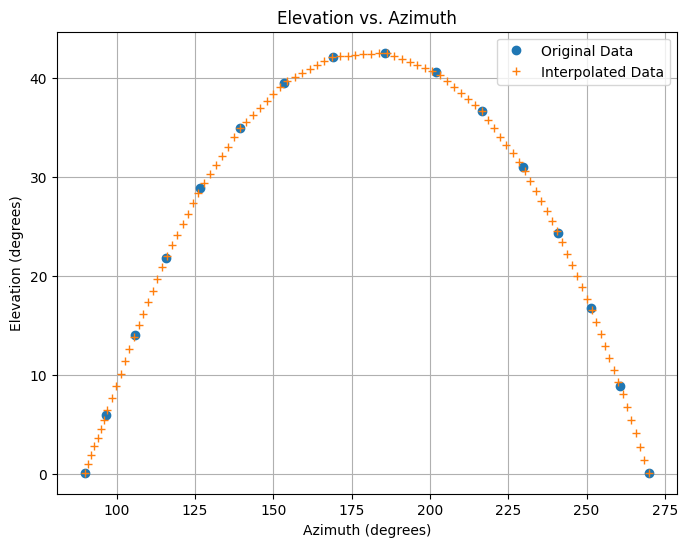

In [32]:
# Plotting Elevation as a function of Azimuth
plt.figure(figsize=(8, 6))
plt.plot(SUN_AZ, SUN_EL, 'o', label='Original Data')
plt.plot(sun_az_interp, sun_el_interp, '+', label='Interpolated Data')
plt.title('Elevation vs. Azimuth')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')
plt.legend()
plt.grid(True)
plt.show()

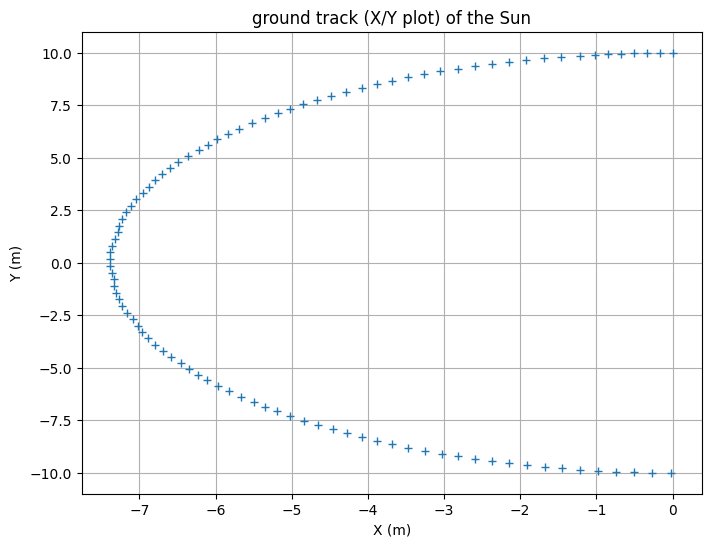

In [33]:
# Plotting Elevation as a function of Azimuth
plt.figure(figsize=(8, 6))
plt.plot(sun_angles[:, 0], sun_angles[:, 1], '+')
plt.grid(True)
plt.title('ground track (X/Y plot) of the Sun')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.show()

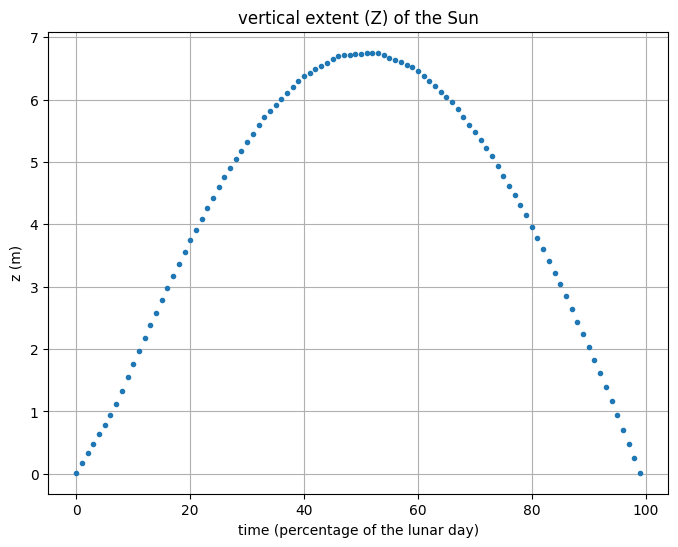

In [34]:
# Plotting Elevation as a function of Azimuth
plt.figure(figsize=(8, 6))
plt.plot(sun_angles[:, 2], '.')
plt.grid(True)
plt.title('vertical extent (Z) of the Sun')
plt.xlabel('time (percentage of the lunar day)')
plt.ylabel('z (m)')

plt.show()

## Full Animation: Thermal

In [35]:
scene = {}

# lunar surface is static so only compute geometric aspects once
data = {}
data['face_vertex_indices'] = prims_utils.get_prim_attribute_value(ground_path, "faceVertexIndices")
data['points_world'] = get_mesh_vertices_world(stage, ground_path)
data['normals'] = get_rect_normals(data['points_world'], data['face_vertex_indices'])
data['quad_centers'] = get_quad_centers(data['points_world'], data['face_vertex_indices'])
data['alpha'] = LUNAR_ALPHA
data['epsilon'] = LUNAR_EPSILON
data['temperatures'] = []
scene['surface'] = data.copy()

# supports are static so only compute geometric aspects once
for i in [1, 2]:
    data = {}
    data['face_vertex_indices'] = prims_utils.get_prim_attribute_value(support1_path[:-1] + str(i), "faceVertexIndices")
    data['points_world'] = get_mesh_vertices_world(stage, support1_path[:-1] + str(i))
    data['quad_centers'] = get_quad_centers(data['points_world'], data['face_vertex_indices'])
    data['normals'] = get_rect_normals(data['points_world'], data['face_vertex_indices'])
    data['rect_areas'] = get_rect_areas(data['points_world'], data['face_vertex_indices'])
    data['alpha'] = SUPPORT_ALPHA
    data['epsilon'] = SUPPORT_EPSILON
    data['temperatures'] = []
    scene[f'support{i}'] = data.copy()

scene['panel'] = {}
scene['panel']['temperatures'] = []

in get_rect_normals(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles


In [36]:
# update computations for panel and sun angle movements 
minmax = [200, 450]
adjust_light(stage, sun_coord, intensity=3e12)
for p,s in zip(panel_angles, sun_angles):
    set_prim_orientation_euler(panel_path, p, degrees=True)
    adjust_light(stage, tuple(s))
    
    timeline.play()
    for _ in range(2):
        simulation_app.update()
    timeline.pause()

    ## independent equation: lunar surface thermal
    data = scene['surface']
    sun_dot_products = compute_sun_to_mesh(data['quad_centers'], output='dotproducts')
    temperatures = compute_thermal_surface(sun_dot_products, data['normals'], data['alpha'], data['epsilon'] )    
    temperature_colors = color_conversion(temperatures, minmax, add_tail=True)
    temperature_colors[100:] = 0  # only keep the top face of the lunar surface, set the other faces to black
    data['temperatures'].append(np.nanmedian(temperatures[:100]))  # only consider the top face of the lunar surface
    #print(np.nanmax(temperatures))
    prims_utils.set_prim_attribute_value(ground_path, "primvars:displayColor", temperature_colors)
    scene['surface'] = data.copy()
    
    ## single node equation: panel and support thermal

    # compute the panel data that changes on each loop
    data = scene['panel']
    data['face_vertex_indices'] = prims_utils.get_prim_attribute_value(panel_path, "faceVertexIndices")
    data['points_world'] = get_mesh_vertices_world(stage, panel_path)
    data['quad_centers'] = get_quad_centers(data['points_world'], data['face_vertex_indices'])
    data['normals'] = get_rect_normals(data['points_world'], data['face_vertex_indices'])
    data['rect_areas'] = get_rect_areas(data['points_world'], data['face_vertex_indices'])
    data['alpha'] = PANEL_ALPHA
    data['epsilon'] = PANEL_EPSILON
    scene['panel'] = data.copy()

    # compute the thermal data for all three nodes
    for node, path in zip(['panel', 'support1', 'support2'], [panel_path, support1_path, support2_path]):
        
        data = scene[node]
        sun_dot_products = compute_sun_to_mesh(data['quad_centers'], output='dotproducts')        
        temperature = compute_thermal_node(
            sun_dot_products,
            data['rect_areas'],
            data['normals'],
            data['alpha'],
            data['epsilon']
        )
        #if node=='panel': print(temperature)
        #print(f"{temperature:.0f} degK")
        data['temperatures'].append(temperature)
        #if node=='panel': print(data['temperatures'])
        scene[node] = data.copy()
        temperature_colors = color_conversion(np.ones(len(data['points_world'])) * temperature, minmax, add_tail=True)
        prims_utils.set_prim_attribute_value(path, "primvars:displayColor", temperature_colors)

    
    world.render()

/home/ljb/jaops/jaops-sim/src/demo_power_thermal/power_thermal_computation.py:175: RuntimeWarning: invalid value encountered in divide
  temperatures = (q_sun / q_space) ** (1 / 4)


in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rectangles
in get_rect_normals(): assuming rectangles
in get_rect_areas(): assuming rec

In [37]:
# quick stats of the temperatures over the entire day:
pprint(quick_stats(scene['panel']['temperatures']), sort_dicts=False)

{'mean': 360.2,
 'median': 360.1,
 'std': 8.8,
 'min': 347.3,
 'max': 374.0,
 '25%': 351.0,
 '50%': 360.1,
 '75%': 368.4,
 'NaN count': 0,
 'NaN %': 0.0}


In [38]:
# quick stats of the temperatures at the last timestep: 
pprint(quick_stats(temperatures[:100]), sort_dicts=False)

{'mean': 80.1,
 'median': 79.8,
 'std': 2.9,
 'min': 75.7,
 'max': 85.3,
 '25%': 77.6,
 '50%': 79.8,
 '75%': 82.5,
 'NaN count': 0,
 'NaN %': 0.0}


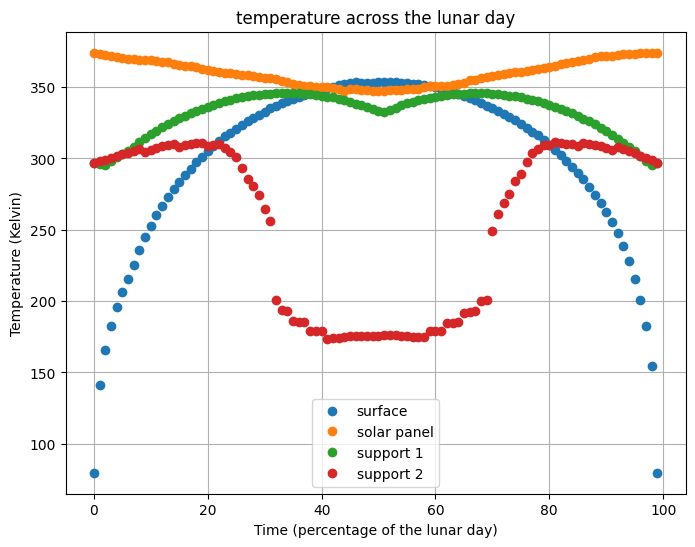

In [39]:
# Plotting Elevation as a function of Azimuth
plt.figure(figsize=(8, 6))

plt.plot(scene['surface']['temperatures'], 'o', label='surface')
plt.plot(scene['panel']['temperatures'], 'o', label='solar panel')
plt.plot(scene['support1']['temperatures'], 'o', label='support 1')
plt.plot(scene['support2']['temperatures'], 'o', label='support 2')

plt.title('temperature across the lunar day')
plt.ylabel('Temperature (Kelvin)')
plt.xlabel('Time (percentage of the lunar day)')
plt.legend()
plt.grid(True)

plt.show()


## Utils

In [40]:
from mesh_raycast_utils import test_cube_face_color, test_cube_vertex_color

In [41]:
# each cube face is a different color:
# face_colors = test_cube_face_color(ground_path)
# prims_utils.set_prim_attribute_value(ground_path, "primvars:displayColor", face_colors)
# world.render()

In [42]:
# each vertex of a cube face is a different color: 
# face_colors = test_cube_vertex_color(ground_path)
# prims_utils.set_prim_attribute_value(ground_path, "primvars:displayColor", face_colors)
# world.render()